# Import Library

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

from sentence_transformers import SentenceTransformer

# Download Stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dimas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Dataset

In [2]:
data_path = "../Dataset/gojek_trimmed_10000.csv"
df = pd.read_csv(data_path)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df.head())

                               reviewId         userName                                          userImage                                            content  score  thumbsUpCount reviewCreatedVersion                   at                                       replyContent            repliedAt appVersion
0  a414e314-d18d-426a-87fc-128a626a0ab0  Pengguna Google  https://play-lh.googleusercontent.com/EGemoI2N...  Halo pihak gopay yang terhormat, akun gopay sa...      1              0               5.11.1  2025-03-01 21:20:38  Hai, Kak Rumiyati, mohon maaf atas kendalanya....  2025-03-02 04:18:58     5.11.1
1  2c68712d-9cce-495b-ad3b-58d0e9cbea93  Pengguna Google  https://play-lh.googleusercontent.com/EGemoI2N...   sangat membantu saya dlm bepergian makasi go jek      5              0               3.30.2  2019-06-28 03:37:49                                                NaN                  NaN     3.30.2
2  017e8287-e2e2-479d-8aae-f2120427a020  Pengguna Google  https://play-lh.googleus

# Preprocessing

## Label Mapping

In [ ]:
def label_mapping(score):
    if score in [1, 2]:
        return "negatif"
    elif score == 3:
        return "netral"
    else:
        return "positif"

df['label'] = df['score'].apply(label_mapping)

## Cleaning

In [5]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    text = " ".join([word for word in text.split() if word not in stop_words])
    return text

df["clean"] = df["content"].apply(clean_text)

## Embedder Sentence Transformers

In [6]:
embedder = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

X_embeddings = embedder.encode(df["clean"], show_progress_bar=True)

y = df["label"]

Batches:   0%|          | 0/938 [00:00<?, ?it/s]

## Split Data

In [7]:
X_train_emb, X_test_emb, y_train, y_test = train_test_split(
    X_embeddings, y, test_size=0.2, random_state=42, stratify=y
)

# Training

In [8]:
clf = LogisticRegression(max_iter=1000, class_weight="balanced")
clf.fit(X_train_emb, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000)

# Prediction and Evaluation

In [9]:
y_pred = clf.predict(X_test_emb)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     negatif       0.60      0.68      0.64      2000
      netral       0.52      0.36      0.43      2000
     positif       0.71      0.83      0.77      2000

    accuracy                           0.62      6000
   macro avg       0.61      0.62      0.61      6000
weighted avg       0.61      0.62      0.61      6000



## Confusion Matrix

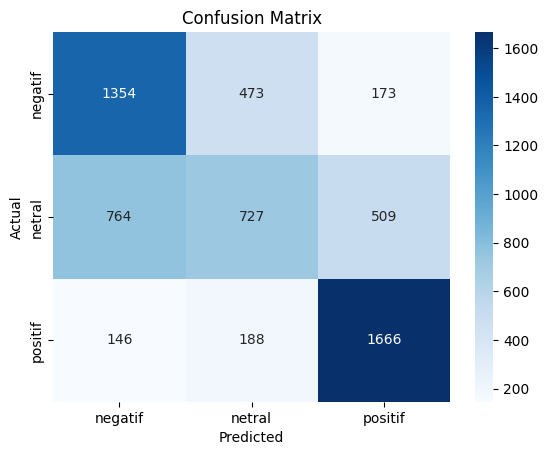

In [10]:
cm = confusion_matrix(y_test, y_pred, labels=["negatif", "netral", "positif"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["negatif", "netral", "positif"],
            yticklabels=["negatif", "netral", "positif"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Save Model and Artifacts

In [ ]:
joblib.dump(clf, "Artifacts/sentiment_classifier.pkl")
joblib.dump(stop_words, "Artifacts/stopwords.pkl")

embedder.save("embedder_model")  

print("Model saved successfully.")

Model saved successfully.
